### Import Libraries:

In [ ]:
!pip install biopython # Install the biopython library which contains the SeqIO module.
from Bio import SeqIO
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import stats
import re

# Set plot style for a cleaner visual appearance
plt.style.use('seaborn-v0_8')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 20.0 MB/s eta 0:00:00


In [ ]:
art = list(SeqIO.parse("MSA_art.faa", "fasta"))

nat = list(SeqIO.parse("MSA_nat_with_annotation.faa", "fasta"))

def one_hot(sequence):
  matrix = np.zeros((21,96))

  amino_acids = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K':8, 'L':9, 'M':10, 'N':11, 'P':12, 'Q':13, 'R':14, 'S':15, 'T':16, 'V':17, 'W':18, 'Y':19, '-':20}

  for i in range(96):
    matrix[amino_acids[sequence[i]], i] = 1

  return matrix.flatten()

def encode(data):
  matrix = np.zeros((len(data),2016))

  for i in range(len(data)):
    matrix[i] = one_hot(data[i].seq)

  return matrix

def label(data):
  label = np.zeros(len(data))
  for i in range(len(data)):
    if re.search(r"functional_true", data[i].description):
      label[i] = 1
    else:
      label[i] = 0

  return label

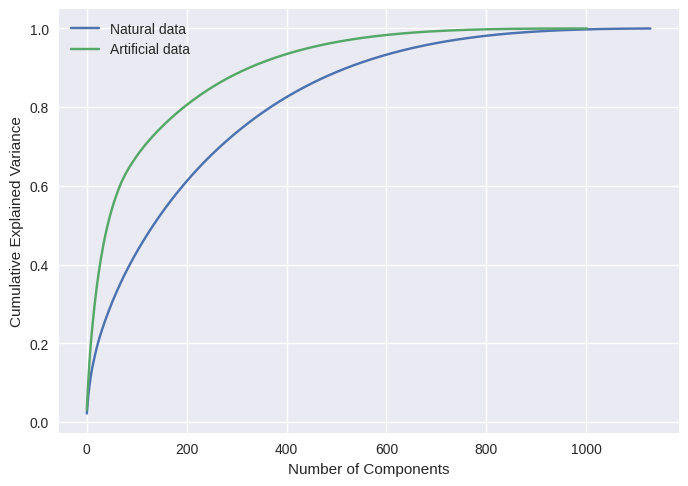

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = encode(nat)
scaler.fit(X)
X = scaler.transform(X)

Y = encode(art)
scaler.fit(Y)
Y = scaler.transform(Y)

# Fit PCA without specifying the number of components to compute variance ratios for all components
pca = PCA().fit(X)
pca_nat = PCA().fit(Y)

# Plot the cumulative explained variance as a function of the number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_), label = "Natural data")  # Cumulative sum of explained variance
plt.plot(np.cumsum(pca_nat.explained_variance_ratio_), label = "Artificial data")
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

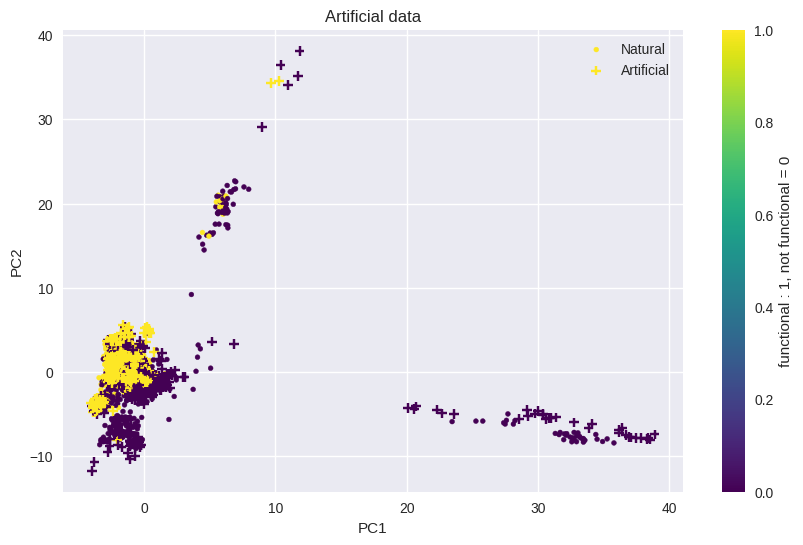

In [9]:
x = label(nat)
y = label(art)

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)
Y_pca = pca.transform(Y)

plt.figure(figsize=(10, 6))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=x, cmap='viridis', label = "Natural", marker = ".")

plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=y, cmap='viridis', label = "Artificial", marker = "+")

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Artificial data')
plt.colorbar(label=r'functional : 1, not functional = 0')
plt.show()

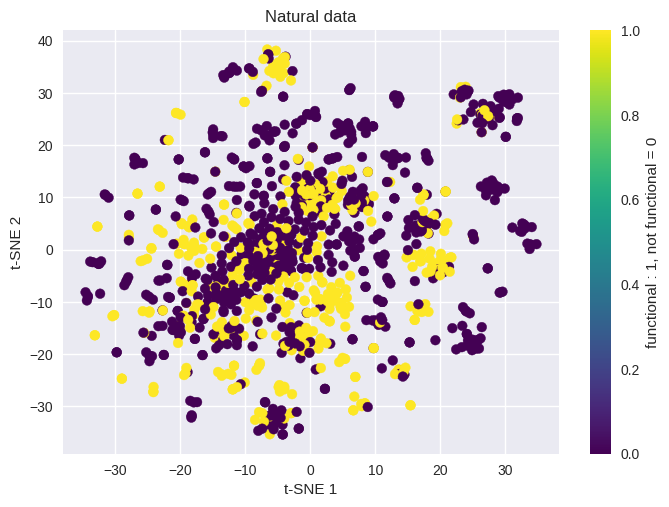

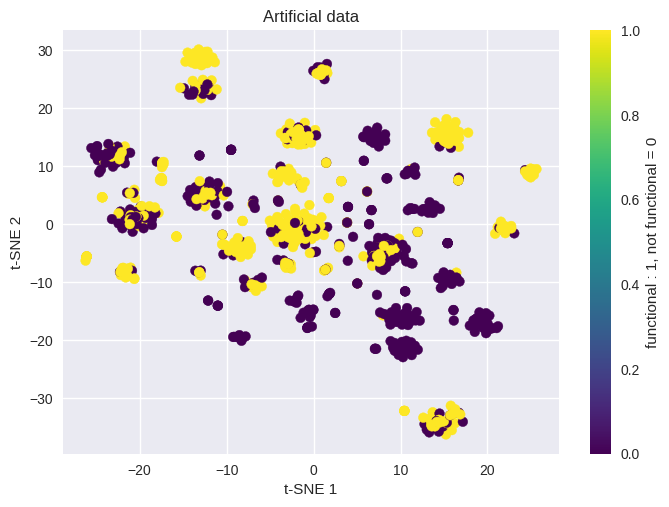

In [ ]:
from sklearn.manifold import TSNE

# Initialize t-SNE to reduce the dimensionality to 2 components with a specified perplexity
tsne = TSNE(n_components=2, perplexity=50)

# Apply t-SNE to the data
X_embedded = tsne.fit_transform(X)
Y_embedded = tsne.fit_transform(Y)

# Create a scatter plot of the t-SNE transformed data
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = x, cmap='viridis')
plt.colorbar(label=r'functional : 1, not functional = 0')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Natural data')
plt.show()

plt.scatter(Y_embedded[:, 0], Y_embedded[:, 1], c = y, cmap='viridis')
plt.colorbar(label=r'functional : 1, not functional = 0')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Artificial data')
plt.show()